# Проект в рамках курса "Интерпретируемый ИИ и майнинг данных"
---

Проект выполнили: Хабибуллин Булат,	Толстов Евгений,	Грицких Максим,	Антон Сорока,	Анастасия Глушкова, Александр Герасимов,	Филиппов Иван

# Первая часть проекта (работа с табличными данными):
Описание: 

## 1. Поиск причинно-следственных связей:

### 1.1 Рассмотреть модель на основе ваших предположений (ориентированных граф без циклов), словами описать, какие зависимости вы рассматривали. Изобразить граф, который вы рассматривали.

In [1]:
# If you are using colab, uncomment this cell
# load data
!wget https://github.com/Makesomenotes/kdd_trading/blob/main/data/financial_data.csv
!wget https://github.com/Makesomenotes/kdd_trading/blob/main/data/S%26P500-Info.csv

!mkdir data
!mv -t data 'financial_data.csv' 'S&P500-Info.csv'

--2021-11-16 17:45:58--  https://github.com/Makesomenotes/kdd_trading/blob/main/data/financial_data.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'financial_data.csv'

     0K .......... .......... .......... .......... .......... 1.36M
    50K .......... .......... .......... .......... .......... 4.55M
   100K .......... .......... .......... .......... .......... 2.55M
   150K .......... .......... .......... .......... .......... 2.49M
   200K .......... .......... .......... .......... .......... 5.02M
   250K .......... .......... .......... .......... .......... 3.83M
   300K .......... .......... .......... .......... .......... 5.45M
   350K .......... .......... .......... .......... .........  3.24M=0.1s

2021-11-16 17:45:59 (2.96 MB/s) - 'financial_data.csv' saved [408827]

--2021-11-16 17:45:59--  https://gi

In [ ]:
# install packages
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install catboost
!pip install shap
!pip install lime

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

import pygraphviz
import dowhy
from dowhy import CausalModel

import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('./data/financial_data.csv', index_col=0)
data = data.dropna()
data_groups = pd.read_csv('data/S&P500-Info.csv', index_col=0)
merged = data.merge(data_groups[['Symbol', 'GICS Sector']], left_index=True, right_on='Symbol')
data_normalized = merged.drop('Symbol', axis=1).drop(['regression_target', 'SP_target'], axis=1)
target_reg = merged.regression_target
target_class = merged.SP_target * 1
data_normalized = data_normalized.groupby('GICS Sector').transform(lambda x: (x - x.mean()) / x.std())
data_normalized['binary_target'] =  target_class
data_normalized.head()

,debt_to_equity,current_ratio,cash_ratio,return_on_assets,eps,price_to_sales,price_to_casflow,shareholder_equity,interest_coverage,net_profit_margin,target,binary_target
0,0.295745,-0.284302,-0.311450,0.776858,-0.019888,0.353524,-0.283078,-0.290284,0.137713,0.499126,0.182600,1
1,0.049463,-0.483011,-0.388863,0.007314,-0.150426,0.885636,2.265313,0.293942,0.151924,0.033890,0.448067,0
2,0.725645,-1.065446,-0.569918,-0.070944,-0.148420,-0.588660,-0.299174,-1.437241,0.226628,0.136852,0.448067,1
4,-0.268530,0.425258,0.639303,0.722458,2.571990,-0.042559,-0.188939,0.442234,-0.797489,-0.172700,0.373210,1
9,4.646424,1.397469,1.239293,-2.132291,-0.526184,-2.027053,-0.125705,-2.677886,0.759492,-1.611807,0.457851,1


In [3]:
# Граф с дополнительными ветвями. Не работает пока что
# causal_graph = """digraph {
# debt_to_equity;
# current_ratio;
# cash_ratio;
# return_on_assets;
# eps;
# price_to_casflow;
# shareholder_equity;
# interest_coverage;
# net_profit_margin;
# A[label="Assets"];
# E[label="Equity"];
# D[label="Debts"];
# R[label="Revenue"];
# M[label="Market cap"];
# binary_target[label="target"];
# debt_to_equity->binary_target;
# current_ratio->binary_target;
# cash_ratio->binary_target;
# return_on_assets->binary_target;
# eps->binary_target;
# price_to_casflow->binary_target;
# shareholder_equity->binary_target;
# interest_coverage->binary_target;
# net_profit_margin->binary_target;
# M->price_to_casflow;
# R->net_profit_margin;
# R->eps;
# A->return_on_assets;
# A->cash_ratio;
# A->current_ratio;
# A->D;
# A->E;
# E->shareholder_equity;
# E->debt_to_equity;
# D->current_ratio;
# D->shareholder_equity;
# D->debt_to_equity;
# }"""

In [4]:
# Граф со склеиными вершинами
causal_graph = """digraph {
debt_to_equity;
current_ratio;
cash_ratio;
return_on_assets;
eps;
price_to_casflow;
shareholder_equity;
interest_coverage;
net_profit_margin;
binary_target[label="target"]
debt_to_equity->binary_target;
current_ratio->binary_target;
cash_ratio->binary_target;
return_on_assets->binary_target;
eps->binary_target;
price_to_casflow->binary_target;
shareholder_equity->binary_target;
interest_coverage->binary_target;
net_profit_margin->binary_target;
net_profit_margin->eps;
return_on_assets->cash_ratio;
cash_ratio->current_ratio;
current_ratio->shareholder_equity;
shareholder_equity->debt_to_equity;
}"""

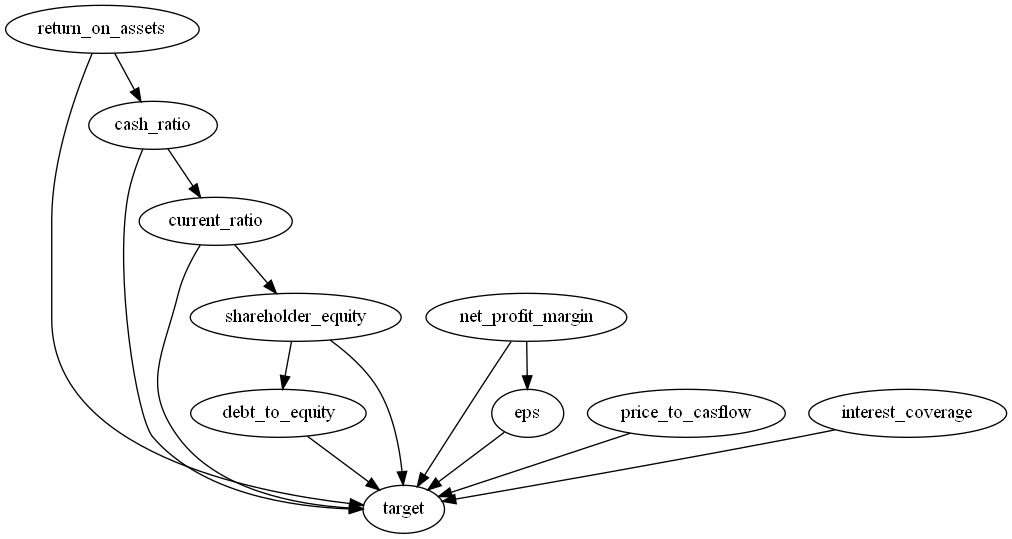

In [5]:
model= dowhy.CausalModel(
        data = data_normalized,
        graph=causal_graph.replace("\n", " "),
        treatment='eps',
        outcome='binary_target')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(binary_target|current_ratio,debt_to_equity,cash_ratio,retur
d[eps]                                                                        

                                                                              
n_on_assets,interest_coverage,price_to_casflow,net_profit_margin,shareholder_e
                                                                              

       
quity))
       
Estimand assumption 1, Unconfoundedness: If U→{eps} and U→binary_target then P(binary_target|eps,current_ratio,debt_to_equity,cash_ratio,return_on_assets,interest_coverage,price_to_casflow,net_profit_margin,shareholder_equity,U) = P(binary_target|eps,current_ratio,debt_to_equity,cash_ratio,return_on_assets,interest_coverage,price_to_casflow,net_profit_margin,shareholder_equity)

### Estimand : 2
Estim

In [7]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",
                                                        target_units="ate")

print(estimate)  # результат MSE примерно 0.11

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(binary_target|current_ratio,debt_to_equity,cash_ratio,retur
d[eps]                                                                        

                                                                              
n_on_assets,interest_coverage,price_to_casflow,net_profit_margin,shareholder_e
                                                                              

       
quity))
       
Estimand assumption 1, Unconfoundedness: If U→{eps} and U→binary_target then P(binary_target|eps,current_ratio,debt_to_equity,cash_ratio,return_on_assets,interest_coverage,price_to_casflow,net_profit_margin,shareholder_equity,U) = P(binary_target|eps,current_ratio,debt_to_equity,cash_ratio,return_on_assets,interest_coverage,price_to_casflow,net_profit_ma

### 1.2 Применить 3 любых “refutation” метода на ваш выбор и обосновать их выбор (какие цели вы преследовали, выбирая эти методы, что вы хотели проверить)


**Опровержение полученной оценки** - часть причинно-следственного анализа, которая позволяет проверить корректность наших предположений и устойчивость построенной оценочной модели.

In [8]:
data_refutation = data_normalized.copy(deep=True)

**Method 1. Random Common Cause**  
Проверим как сильно изменится полученная оценка причинно-следственного эффекта (estimated causal effect) при добавлении независимо случайно сгенерированной переменной как одной из общих причин (Random Common Cause)

In [9]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.11212712736722807
New effect:0.1097692692132366



***Вывод:*** Незначительное изменение оценки причинно-следственного эффекта при добавлении Random Common Cause говорит о стабильности оценочной модели и справедливости нашего изначального предположения.

**Method 2. Data Subsets Validation**  
Проверим как сильно изменится полученная оценка причинно-следственного эффекта (estimated causal effect) если удалить 10% данных.

In [10]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter",
        subset_fraction=0.9) # Percentage of data extracted from the underlying data
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.11212712736722807
New effect:0.11688783196000849
p value:0.49



***Вывод:*** Новая оценка причинно-следственного эффекта практически не изменилась, что говорит об устойчивости построенной модели.

**Method 3. Placebo Treatment**  
Проверим как сильно изменится полученная оценка причинно-следственного эффекта (estimated causal effect) если заменить treatment переменную (treatment variable) независимой случайно сгенерированной пременной.

In [11]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter",
        placebo_type="permute")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.11212712736722807
New effect:-0.002005605039160331
p value:0.48



***Вывод:*** Новая оценка причинно-следственного эффекта близка к нулю с высоким уровнем значимости (p-value), что говорит о справедливости наших предположений.

### 1.3. Применить все то же самое для графовой модели, используемой по умолчанию. Получили ли вы те же результаты?

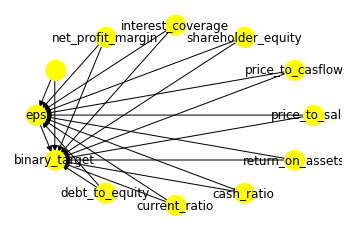

In [13]:
xs = ""
for i in ['debt_to_equity',
 'current_ratio',
 'cash_ratio',
 'return_on_assets',
 'price_to_sales',
 'price_to_casflow',
 'shareholder_equity',
 'interest_coverage',
 'net_profit_margin',
]:
    xs += (str(i)+"+")

xs.split('+')

model0 = dowhy.CausalModel(
        data = data_normalized,
        treatment='eps',
        outcome='binary_target',
        common_causes=xs.split('+')
)

model0.view_model()
# from IPython.display import Image, display
# display(Image(filename="causal_model0.png"))

In [14]:
#Identify the causal effect
identified_estimand0 = model0.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand0)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(binary_target|cash_ratio,debt_to_equity,return_on_assets,cu
d[eps]                                                                        

                                                                              
rrent_ratio,price_to_casflow,price_to_sales,shareholder_equity,interest_covera
                                                                              

                      
ge,net_profit_margin))
                      
Estimand assumption 1, Unconfoundedness: If U→{eps} and U→binary_target then P(binary_target|eps,cash_ratio,debt_to_equity,return_on_assets,current_ratio,price_to_casflow,price_to_sales,shareholder_equity,interest_coverage,net_profit_margin,U) = P(binary_target|eps,cash_ratio,debt_to_equity,return_on_assets,current_ratio,price_to_casflow,price_to_sales,shar

In [15]:
estimate0 = model0.estimate_effect(identified_estimand0, method_name="backdoor.linear_regression",
                                                        target_units="ate")

print(estimate0)  

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(binary_target|cash_ratio,debt_to_equity,return_on_assets,cu
d[eps]                                                                        

                                                                              
rrent_ratio,price_to_casflow,price_to_sales,shareholder_equity,interest_covera
                                                                              

                      
ge,net_profit_margin))
                      
Estimand assumption 1, Unconfoundedness: If U→{eps} and U→binary_target then P(binary_target|eps,cash_ratio,debt_to_equity,return_on_assets,current_ratio,price_to_casflow,price_to_sales,shareholder_equity,interest_coverage,net_profit_margin,U) = P(binary_target|eps,cash_ratio,debt_to_equity,return_on_assets,cu

In [16]:
data_refutation0 = data_normalized.copy(deep=True)

**Method 1**

In [17]:
refute1_results0=model0.refute_estimate(identified_estimand0, estimate0,
        method_name="random_common_cause")
print(refute1_results0)

Refute: Add a Random Common Cause
Estimated effect:0.036212113578955596
New effect:0.037822419880501945



***Вывод:*** аналогично п.1.2

**Method 2**

In [18]:
refute3_results0=model0.refute_estimate(identified_estimand0, estimate0,
        method_name="data_subset_refuter",
        subset_fraction=0.9) # Percentage of data extracted from the underlying data
print(refute3_results0)

Refute: Use a subset of data
Estimated effect:0.036212113578955596
New effect:0.03521193640850208
p value:0.36



***Вывод:*** аналогично п.1.2

**Method 3**

In [19]:
refute2_results0=model0.refute_estimate(identified_estimand0, estimate0,
        method_name="placebo_treatment_refuter",
        placebo_type="permute")
print(refute2_results0)

Refute: Use a Placebo Treatment
Estimated effect:0.036212113578955596
New effect:0.0008631525902102399
p value:0.43



***Вывод:*** аналогично п.1.2

## 2. Обучение моделей черного ящика:

In [11]:
data = pd.read_csv('data/financial_data.csv', index_col=0)
data = data.drop(['price_to_sales', 'target'], axis=1)
data = data.dropna()

data_groups = pd.read_csv('data/S&P500-Info.csv', index_col=0)
merged = data.merge(data_groups[['Symbol', 'GICS Sector']], left_index=True, right_on='Symbol')
X = merged.drop('Symbol', axis=1).drop(['regression_target', 'SP_target'], axis=1)
target_reg = merged.regression_target
target_class = merged.SP_target * 1

In [12]:
X_train_df, X_test_df, y_train_reg, y_test_reg = train_test_split(X, target_reg.values, test_size=0.3, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, target_class.values, test_size=0.3, random_state=42)

In [13]:
X_train = X_train_df.groupby('GICS Sector').transform(lambda x: (x - x.mean()) / x.std())
X_test_mean = X_test_df.merge(X_train_df.groupby('GICS Sector').mean(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean.merge(X_train_df.groupby('GICS Sector').std(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean_std.drop('GICS Sector', axis=1)
X_test = (X_test_mean_std.iloc[:, :9].values - X_test_mean_std.iloc[:, 9:18].values)/X_test_mean_std.iloc[:, 18:].values

### 2.1 Regression 

#### LinearRegression

In [14]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train_reg)
pred = reg_model.predict(X_test)

In [6]:
print(f'Train MSE: {mean_squared_error(reg_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.028117
Test MSE: 0.052553


#### Ridge

In [ ]:
ridge_model = Ridge(alpha=2.0, random_state=42)
ridge_model.fit(X_train, y_train_reg)
pred = ridge_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(ridge_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.028117
Test MSE: 0.052999


#### Lasso

In [ ]:
lasso_model = Lasso(alpha=2.0, random_state=42)
lasso_model.fit(X_train, y_train_reg)
pred = lasso_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(lasso_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031893
Test MSE: 0.031381


#### ElasticNet

In [ ]:
elastic_model = ElasticNet(alpha=2.0, random_state=42)
elastic_model.fit(X_train, y_train_reg)
pred = elastic_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(elastic_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031893
Test MSE: 0.031381


#### SGDRegressor - l2

In [ ]:
SGD_model_l2 = SGDRegressor(loss='squared_loss', penalty='l2', alpha=20.0, random_state=42)
SGD_model_l2.fit(X_train, y_train_reg)
pred = SGD_model_l2.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(SGD_model_l2.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031143
Test MSE: 0.03138


#### SGDRegressor - l1

In [ ]:
SGD_model_l1 = SGDRegressor(loss='squared_loss', penalty='l1', alpha=2.0, random_state=42)
SGD_model_l1.fit(X_train, y_train_reg)
pred = SGD_model_l1.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(SGD_model_l1.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031935
Test MSE: 0.031524


#### RandomForestRegressor

In [ ]:
RF = RandomForestRegressor(criterion='mae', n_estimators=100, min_samples_leaf=1, max_depth=2, random_state=42)
RF.fit(X_train, y_train_reg)
pred = RF.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(RF.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.023802
Test MSE: 0.032969


In [ ]:
RF = RandomForestRegressor(criterion='mse', n_estimators=150, min_samples_leaf=1, max_depth=2, random_state=42)
RF.fit(X_train, y_train_reg)
pred = RF.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(RF.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.023353
Test MSE: 0.032984


#### XGBoost

In [ ]:
XGB_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators=50, max_depth=1, learning_rate=0.05, seed=42)
XGB_model.fit(X_train, y_train_reg)
pred = XGB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(XGB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.025938
Test MSE: 0.033233


#### CatBoost

In [ ]:
CB_model = CatBoostRegressor(learning_rate=1e-5, loss_function='MAE', depth=2, random_seed=42)
CB_model.fit(X_train, y_train_reg, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(CB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031839
Test MSE: 0.031351


In [ ]:
CB_model = CatBoostRegressor(learning_rate=1e-5, loss_function='RMSE', depth=2, random_seed=42)
CB_model.fit(X_train, y_train_reg, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(CB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.03183
Test MSE: 0.031375


#### NN

In [ ]:
NN_model = MLPRegressor(hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver='adam', random_state=42)
NN_model.fit(X_train, y_train_reg)
pred = NN_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(NN_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.030467
Test MSE: 0.03192


### 2.2 Classification

#### LogisticRegression

In [ ]:
LR_model = LogisticRegression(penalty='l2', random_state=42)
LR_model.fit(X_train, y_train_class)
pred = LR_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(LR_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 64.75
Test Accuracy: 58.1


#### SGDClassifier

In [ ]:
SGDClassifier_model = SGDClassifier(loss='log', penalty='l2', random_state=42)
SGDClassifier_model.fit(X_train, y_train_class)
pred = SGDClassifier_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(SGDClassifier_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 58.61
Test Accuracy: 60.0


#### RandomForestClassifier

In [ ]:
RF_model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=7, max_depth=2, random_state=42)
RF_model.fit(X_train, y_train_class)
pred = RF_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(RF_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 70.9
Test Accuracy: 65.71


#### XGBoost

In [ ]:
XGB_model = xg.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.0005, use_label_encoder=False, random_state=42)
XGB_model.fit(X_train, y_train_class)
pred = XGB_model.predict(X_test)

[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print(f'Train Accuracy: {accuracy_score(XGB_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 69.26
Test Accuracy: 61.9


#### CatBoost

In [ ]:
CB_model = CatBoostClassifier(learning_rate=1e-4, depth=3, random_seed=42)
CB_model.fit(X_train, y_train_class, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(CB_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 70.08
Test Accuracy: 63.81


#### NN

In [ ]:
NN_model = MLPClassifier(hidden_layer_sizes=(50, 100, 50), alpha=0, learning_rate_init=0.5,
                         max_iter=1500, solver='adam')
NN_model.fit(X_train, y_train_class)
pred = NN_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(NN_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 60.66
Test Accuracy: 60.95


## 3. Применение SHAP

### 3.1. Сравнить важность признаков, получаемую с помощью SHAP с важностью признаков, получаемую с помощью модели на основе ансамбля деревьев решений. Прокомментировать результат (Есть ли разница? Можете ли вы это объяснить?). 

In [ ]:
import shap

In [ ]:
# CB_model = CatBoostClassifier(learning_rate=1e-4, depth=3, random_seed=42)
# CB_model.fit(X_train, y_train_class, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
X = pd.concat([X_train, X_test]) 
y = np.concatenate([y_train_class, y_test_class])

In [ ]:
X = X.reset_index(drop=True)

In [ ]:
# важность признаков SHAP

In [ ]:
explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(Pool(X, y))

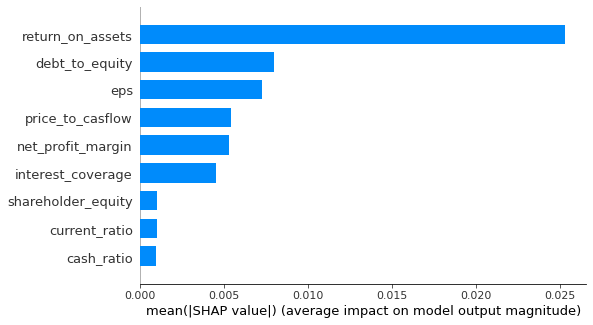

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

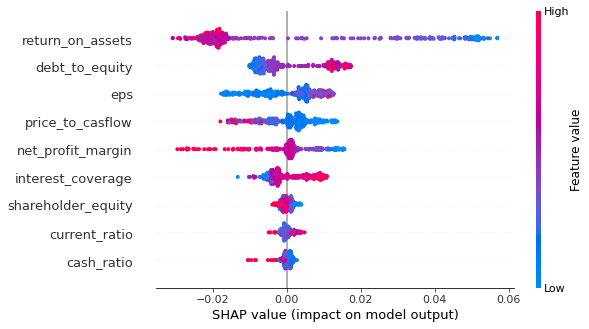

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
# важность признаков на основе ансамбля деревьев

In [ ]:
pd.DataFrame(CB_model.get_feature_importance(prettified=True)).head(20)

,Feature Id,Importances
0,return_on_assets,37.281580
1,eps,12.925771
2,net_profit_margin,11.342015
3,debt_to_equity,10.573310
4,price_to_casflow,10.412142
5,interest_coverage,6.133038
6,current_ratio,4.255519
7,shareholder_equity,3.606240
8,cash_ratio,3.470384


__Вывод__: разница есть, т.к. важности признаков строятся по разным методикам. 

    В первом случае - это SHAP values. Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (например, для каждого клиента в выборке) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи. 

    Во-втором случае, взят для примера встроенный метод get_feature_importance от реализации градиентного бустинга catboost. Он показывает для каждой i-ой фичи насколько меняется предсказание модели при изменении важности признака. 

### 3.2. Среди 3 методов, выбрать один, который обеспечивает наилучшее качества решения. Проанализировать SHAP-values для всего набора данных в целом. Меняется ли существенно важность признаков внутри класса и между классами? Какие признаки наиболее важны?

In [ ]:
# TODO

### 3.3. Для того же метода, что и в вопросе выше, выбрать 2 примера из разных классов, где модель дает правильный ответ, и 2 примера из разных классов, где модель ошибается. Проанализировать эти примеры для всех 3 моделей с помощью SHAP. Похожи ли объяснения? (Внимание: 4 картинки * 3 модели = 12 примеров).

In [ ]:
df_full = X.copy()
df_full['y_pred'] = CB_model.predict(X)
df_full['y_pred_proba'] = CB_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

In [ ]:
df_full.head()

,debt_to_equity,current_ratio,cash_ratio,return_on_assets,eps,price_to_casflow,shareholder_equity,interest_coverage,net_profit_margin,y_pred,y_true
0,-0.058664,0.062880,-0.278166,0.423497,0.330525,2.811967,0.638116,0.014439,0.372865,1,1
1,4.840815,-0.820426,-0.427122,0.049725,0.196237,-0.205543,-1.081221,0.244289,-0.117257,1,0
2,0.023873,-0.789428,-0.351349,-1.149992,0.154927,-0.205610,-0.582956,0.270670,-1.125962,1,1
3,-0.223837,-0.153447,-0.505887,-0.108256,-0.332992,-0.605507,-0.327450,0.243661,-0.318146,1,0
4,0.142296,-0.977748,-0.673773,0.884381,0.213255,0.195786,-1.970890,0.164358,0.336564,1,0


#### Catboost model

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

__Вывод:__ по отдельным примерам видно, как признаки из топа SHAP-values влияют на предсказание модели. Например, в случае, где модель проставила правильно класс 0, feature 4 (EPS) "тянет" пример к классу 0. Это видно и на суммарном графике summary_plot, где чем ниже EPS, тем более это склоняет пример к классу 0. Аналогично с классом 1, где высокое значение EPS тянет пример к классу 1.

### LogisticRegression

In [ ]:
# LR_model = LogisticRegression(penalty='l2', random_state=42)
# LR_model.fit(X, y)


df_full['y_pred'] = LR_model.predict(X)
df_full['y_pred_proba'] = LR_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

In [ ]:
explainer = shap.Explainer(LR_model, X)
shap_values = explainer(X)

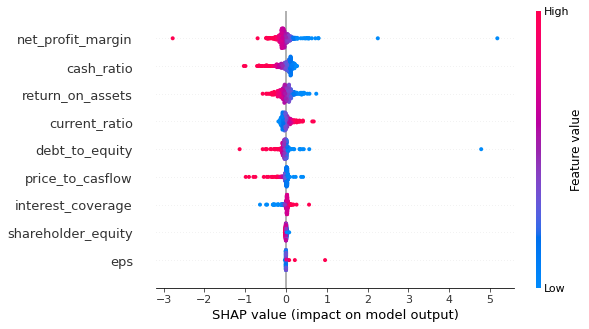

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

__Вывод:__ качество модели хуже, чем у градиентного бустинга, поэтому на общем summary_plot видно, как плохо признаки разделяют примеры на классы. По конкретным примерам видно, например, что высокие значения Current_ratio склоняют примеры к классу 1, а низкие наоборот.

### SGDClassifier

In [ ]:
# SGDClassifier_model = SGDClassifier(loss='perceptron', penalty='l2', random_state=42)
# SGDClassifier_model.fit(X_train, y_train_class)


df_full['y_pred'] = SGDClassifier_model.predict(X)
df_full['y_true'] = y

In [ ]:
explainer = shap.Explainer(SGDClassifier_model, X)
shap_values = explainer(X)

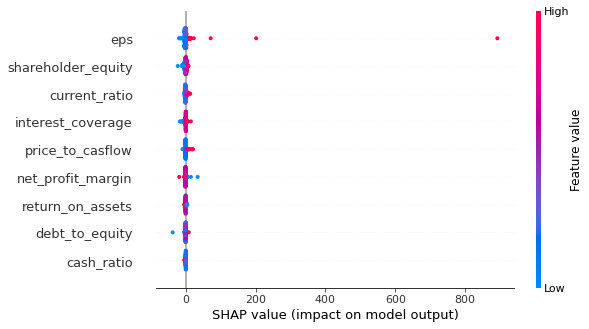

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.force_plot(shap_values[ind])

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

__Вывод:__ эта модель показало еще более худшее качество, поэтому и по SHAP values на общем графике виден низкий вклад разных фичей и сильный разброс на конкретных примерах.

## 4. Применение LIME

### 4.1 Применить LIME к тем же моделям и тем же примерам, что и в предыдущем задании ( 4 картинки * 3 модели = 12 примеров). Получили ли вы похожее объяснения, что и в предыдущем примере? Если нет, можете ли вы это объяснить.

In [ ]:
import lime
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns)                                                 categorical_names=categorical_names)

n_explanations = 10

__Catboost__

In [ ]:
df_full = X.copy()
df_full['y_pred'] = CB_model.predict(X)
df_full['y_pred_proba'] = CB_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

predict_fn = lambda x: CB_model.predict_proba(x)

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

__Logistic Regression__

In [ ]:
df_full = X.copy()
df_full['y_pred'] = LR_model.predict(X)
df_full['y_pred_proba'] = LR_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

predict_fn = lambda x: LR_model.predict_proba(x)

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

__SGD__

In [ ]:
df_full = X.copy()
df_full['y_pred'] = SGDClassifier_model.predict(X)
df_full['y_pred_proba'] = SGDClassifier_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

predict_fn = lambda x: SGDClassifier_model.predict_proba(x)

In [ ]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

In [ ]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].index[0]

exp = lime_explainer.explain_instance(X.iloc[ind], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

__Вывод:__ Результаты по моделям оказались схожи с SHAP, но не идентичны. Различия могли получиться из-за разных подходов в алгоритмах.

### Вывод по первой части:  
* Какие из ваших гипотез подтвердились?
* Какие из результатов оказались ожидаемы?
* Получили ли вы неожиданные результаты? Если да, можете ли вы их объяснить?